# 3. 인물사진을 만들어 보자
## 3-1. 들어가며

피사체를 가깝게 찍을 때 배경이 흐려지는 효과를 경험해 보신 적이 있으신가요? 보통은 DSLR이나 미러리스 같은 전문적인 카메라와 렌즈에서 만들어 내기 쉬운 효과입니다. 하지만 피사체를 충분히 가까운 거리에 두고 촬영한다면 핸드폰 카메라에서도 비슷한 효과를 낼 수 있습니다.

특히 2개 이상의 렌즈를 탑재한 최신 핸드폰에서는 '인물사진 모드(portrait mode)' 가 지원됩니다.

- iPhone에서 인물 사진 모드 사용하기(https://support.apple.com/ko-kr/guide/iphone/iphd7d3a91a2/ios)

핸드폰 카메라의 인물사진 모드는 듀얼 카메라를 이용해 DSLR의 아웃포커싱 기능을 흉내 냅니다. 물론 인물사진의 아웃포커싱 구현은 DSLR의 아웃포커싱 구현과는 다릅니다.

- DSLR에서는 사진을 촬영할 때 피사계 심도(depth of field, DOF)(https://ko.wikipedia.org/wiki/피사계_심도)를 얕게 하여 초점이 맞은 피사체를 제외한 배경을 흐리게 만듭니다.
- 핸드폰 인물사진 모드는 화각이 다른 두 렌즈를 사용합니다. 일반(광각) 렌즈에서는 배경을 촬영하고 망원 렌즈에서는 인물을 촬영한 뒷배경을 흐리게 처리한 후 망원 렌즈의 인물과 적절하게 합성합니다.

오늘 만들어볼 목표는 핸드폰 인물사진 모드입니다. 사실 핸드폰 인물 사진 모드를 정확히 따라 하기 위해서 2개의 렌즈가 필요하지만 딥러닝을 적용해서 하나의 렌즈만으로 비슷하게 흉내 내 보겠습니다.

**인물사진 모드에서 사용되는 용어**

한국에서는 배경을 흐리게 하는 기술을 주로 '아웃포커싱'이라고 표현합니다. 하지만 아웃포커싱은 한국에서만 사용하는 용어이고 정확한 영어 표현은 얕은 피사계 심도(shallow depth of field) 또는 셸로우 포커스(shallow focus) 라고 합니다.

또한 "보케(bokeh)"라는 일본어에서 유래된 표현 또한 많이 사용합니다. 영문권에서도 많이 사용하는 용어지만 사실 전문적으로 사진을 다루시는 분이 아니라면 그 의미가 직관적으로 다가오기 어렵습니다. 핸드폰 제조사에서도 이것을 알고 '인물사진(portrait)'이라는 직관적인 용어를 잘 만들어 낸 것 같습니다.

### 학습 목표
---
- 딥러닝을 적용하여 핸드폰 인물 사진 모드를 따라 해봅니다.

### 학습 내용
---
- 셸로우 포커스 만들기 (1) 사진을 준비하자
- 셸로우 포커스 만들기 (2) 세그멘테이션으로 사람 분리하기
- 셸로우 포커스 만들기 (3) 시맨틱 세그멘테이션 다뤄보기
- 셸로우 포커스 만들기 (4) 배경 흐리게 하기
- 셸로우 포커스 만들기 (5) 흐린 배경과 원본 영상 합성

### 준비물
---
오늘 실습을 위한 폴더를 만들고, 데이터 폴더를 연결해주세요.

> mkdir -p ~/aiffel/human_segmentation/models
mkdir -p ~/aiffel/human_segmentation/images
ln -s ~/data/* ~/aiffel/human_segmentation/images

## 3-2. 셸로우 포커스 만들기 (1) 사진을 준비하자

### 하나의 카메라로 셸로우 포커스(shallow focus)를 만드는 방법
---
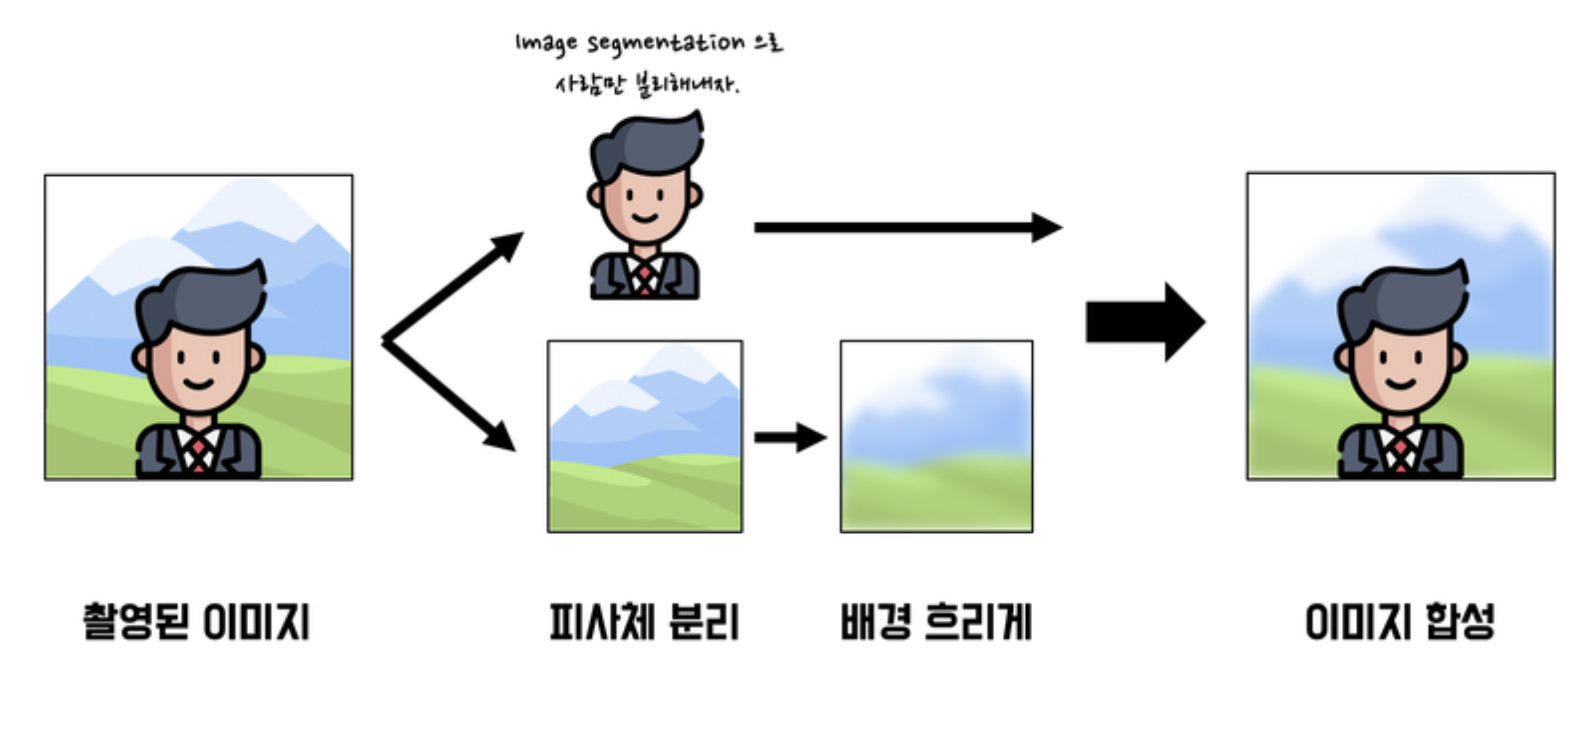

두 개의 렌즈가 맡은 역할을 하나의 렌즈에서 구현해야 합니다. 이미지 세그멘테이션(image segmentation) 기술을 이용하면 하나의 이미지에서 배경과 사람을 분리할 수 있습니다. 분리된 배경을 블러(blur) 처리 후 사람 이미지와 다시 합하면 아웃포커싱 효과를 적용한 인물 사진을 얻을 수 있습니다.

따라서 우리는 다음과 같은 후가공으로 '인물사진 모드'인 사진을 만들 겁니다.

1. 배경이 있는 셀카를 촬영합니다. (배경과 사람의 거리가 약간 멀리 있으면 좋습니다.)
2. 시맨틱 세그멘테이션(Semantic segmentation)으로 피사체(사람)와 배경을 분리합니다.
3. 블러링(blurring) 기술로 배경을 흐리게 합니다.
4. 피사체를 배경의 원래 위치에 합성합니다.

### 사진을 준비하자
---
사진을 준비하겠습니다.


In [1]:
# os: Operating System의 줄임말로, 운영체제에서 제공되는 여러 기능을 파이썬에서 사용할 수 있도록 함 (Ex. 디렉토리 경로 이동, 시스템 환경 변수 가져오기 등)
# urllib: URL 작업을 위한 여러 모듈을 모은 패키지. (Ex. urllib.request, urllib.parse, ...)
# cv2: OpenCV 라이브러리로, 실시간 컴퓨터 비전을 목적으로 한 프로그래밍 라이브러리
# numpy(NumPy): 행렬이나 대규모 다차원 배열을 쉽게 처리할 수 있도록 지원하는 라이브러리. 데이터 구조 외에도 수치 계산을 위해 효율적으로 구현된 기능을 제공
# pixellib: 이미지 및 비디오 segmentation을 수행하기 위한 라이브러리. 
# pixellib.semantic: segmentation 기법 중, semantic segmentation을 쉽게 사용할 수 있도록 만든 라이브러리
# matplotlib: 파이썬 프로그래밍 언어 및 수학적 확장 NumPy 라이브러리를 활용한 플로팅 라이브러리로, 데이터 시각화 도구
import os
import urllib
import cv2
import numpy as np
from pixellib.semantic import semantic_segmentation
from matplotlib import pyplot as plt

print('슝=3')

슝=3


urllib는 웹에서 데이터를 다운로드할 때 사용합니다.
cv2는 OpenCV 라이브러리로 이미지를 처리하기 위해 필요합니다.
pixellib는 시맨틱 세그멘테이션을 편하게 사용할 수 있는 라이브러리인데요. 아직 시맨틱 세그멘테이션 모델을 직접 만들기에는 어려우니 이번에는 준비된 모델을 사용만 해봅니다.
이제 라이브러리에 대해 이해가 되었으니 시작해 볼게요.

준비한 이미지를 읽습니다.

(500, 892, 3)


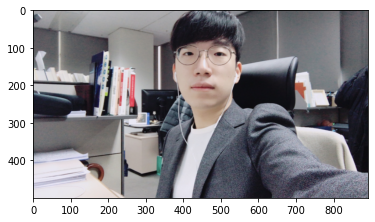

In [2]:
# os 모듈에 있는 getenv() 함수를 이용하여 읽고싶은 파일의 경로를 file_path에 저장
# 준비한 이미지 파일의 경로를 이용하여, 이미지 파일을 읽음
# cv2.imread(경로): 경로에 해당하는 이미지 파일을 읽어서 변수에 저장
img_path = os.getenv('HOME')+'/aiffel/workplace/240605-human-segmentation/images/my_image.png'  
img_orig = cv2.imread(img_path) 

print(img_orig.shape)

# cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
# cv2.COLOR_BGR2RGB: 이미지 색상 채널을 변경 (BGR 형식을 RGB 형식으로 변경)
# plt.imshow(): 저장된 데이터를 이미지의 형식으로 표시, 입력은 RGB(A) 데이터 혹은 2D 스칼라 데이터
# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.imshow.html
# plt.show(): 현재 열려있는 모든 figure를 표시 (여기서 figure는 이미지, 그래프 등)
# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.show.html
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

## 3-3. 셸로우 포커스 만들기 (2) 세그멘테이션으로 사람 분리하기

배경에만 렌즈 흐림 효과를 주기 위해서 그림과 같이 이미지에서 사람과 피사체를 분리해야 합니다. 흔히 포토샵으로 '누끼 따기'라는 것이 바로 이런 작업을 말합니다. 인물 사진에서 배경만 다르게 편집하려는 용도로 흔히 하는 작업이지요.

### 세그멘테이션(Segmentation)이 뭔가요?
---
이미지에서 픽셀 단위로 관심 객체를 추출하는 방법을 이미지 세그멘테이션(image segmentation) 이라고 합니다. 이미지 세그멘테이션은 모든 픽셀에 라벨(label)을 할당하고, 라벨이 같은 객체들은 "공통적인 특징"을 가진다고 가정합니다. 이때 공통 특징은 물리적 의미가 없을 수도 있습니다. 픽셀이 비슷하게 생겼다는 사실은 인식하지만, 우리가 아는 것처럼 실제 물체 단위로 인식하지 않을 수 있는 것이죠. 물론 세그멘테이션에는 여러 가지 세부 태스크가 있으며, 태스크에 따라 다양한 기준으로 객체를 추출합니다.

시맨틱 세그멘테이션(semantic segmentation)이란?

세그멘테이션 중에서도 특히, 우리가 인식하는 세계처럼 물리적 의미 단위로 인식하는 세그멘테이션을 시맨틱 세그멘테이션 이라고 합니다. 쉽게 설명하면 이미지에서 픽셀을 사람, 자동차, 비행기 등의 물리적 단위로 분류(classification)하는 방법이라고 이해하시면 됩니다.
 오늘 다룰 세그멘테이션 방법이기도 하죠.

인스턴스 세그멘테이션(Instance segmentation)이란?

시맨틱 세그멘테이션은 '사람'이라는 추상적인 정보를 이미지에서 추출해 내는 방법입니다. 그래서 사람이 누구인지 관계없이 같은 라벨로 표현이 됩니다.

더 나아가서 인스턴스 세그멘테이션은 사람 개개인별로 다른 라벨을 가지게 합니다. 여러 사람이 한 이미지에 등장할 때 각 객체를 분할해서 인식하자는 것이 목표입니다.

### 딥러닝에 기반한 방법 이전에는 어떻게 이미지 세그멘테이션을 했을까?
---
워터쉐드 세그멘테이션(watershed segmentation)

이미지에서 영역을 분할하는 가장 간단한 방법은 물체의 '경계'를 나누는 것입니다. 그럼 경계는 어떻게 나눌 수 있을까요?

이미지는 그레이스케일(grayscale)로 변환하면 0~255의 값을 가집니다. 픽셀 값을 이용해서 각 위치의 높고 낮음을 구분할 수 있습니다. 낮은 부분부터 서서히 '물'을 채워 나간다고 생각하면 각 영역에서 점점 물이 차오르다가 넘치는 시점이 생기게 됩니다. 그 부분을 경계선으로 만들면 물체를 서로 구분할 수 있게 됩니다.

자세한 내용은 opencv-python tutorial(https://opencv-python.readthedocs.io/en/latest/doc/27.imageWaterShed/imageWaterShed.html)을 참고해 주세요. 오늘 수업에서는 자세하게 다루지 않습니다.

## 3-4. 셸로우 포커스 만들기 (3) 시맨틱 세그멘테이션 다뤄보기

본격적으로 세그멘테이션을 다루어 보겠습니다. 세그멘테이션 문제에는 FCN, SegNet, U-Net 등 많은 모델이 사용됩니다. 오늘은 그중에서 DeepLab이라는 세그멘테이션 모델을 이용해 볼 건데요. DeepLab 알고리즘(DeepLab v3+)은 세그멘테이션 모델 중에서도 성능이 매우 좋아 최근까지도 많이 사용되고 있습니다.

오늘은 네트워크에 대한 자세한 설명보다 세그멘테이션의 활용 방법 위주로 다루겠습니다.

DeepLab에 대한 자세한 설명은 여기를 참고해 주세요.

- DeepLab V3+: Encoder-Decoder with Atrous Separable Convolution for Semantic Image Segmentation (https://lms.aiffel.io/course/946/node/1049/step/6510)

Xception 더 알아보기 (https://arxiv.org/abs/1610.02357)

DeepLab 모델을 준비하겠습니다. 아까 준비한 PixelLib를 이용하면 편하게 사용할 수 있습니다.

https://github.com/ayoolaolafenwa/PixelLib

먼저 PixelLib에서 제공해 주는 모델을 다운로드합니다.

In [3]:
# 저장할 파일 이름을 결정합니다
# 1. os.getenv(x)함수는 환경 변수x의 값을 포함하는 문자열 변수를 반환합니다. model_dir 에 "/aiffel/human_segmentation/models" 저장
# 2. #os.path.join(a, b)는 경로를 병합하여 새 경로 생성 model_file 에 "/aiffel/aiffel/human_segmentation/models/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5" 저장
# 1
model_dir = os.getenv('HOME')+'/aiffel/workplace/240605-human-segmentation/models' 
# 2
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5') 

# PixelLib가 제공하는 모델의 url입니다
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5' 

# 다운로드를 시작합니다
urllib.request.urlretrieve(model_url, model_file) # urllib 패키지 내에 있는 request 모듈의 urlretrieve 함수를 이용해서 model_url에 있는 파일을 다운로드 해서 model_file 파일명으로 저장

('/aiffel/aiffel/workplace/240605-human-segmentation/models/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5',
 <http.client.HTTPMessage at 0x7bd1f1b377f0>)

In [4]:
model = semantic_segmentation() #PixelLib 라이브러리 에서 가져온 클래스를 가져와서 semantic segmentation을 수행하는 클래스 인스턴스를 만듬
model.load_pascalvoc_model(model_file) # pascal voc에 대해 훈련된 예외 모델(model_file)을 로드하는 함수를 호출

In [5]:
segvalues, output = model.segmentAsPascalvoc(img_path) # segmentAsPascalvoc()함 수 를 호출 하여 입력된 이미지를 분할, 분할 출력의 배열을 가져옴, 분할 은 pacalvoc 데이터로 학습된 모델을 이용

segmentAsPascalvoc라는 함수 이름에서 세그멘테이션 모델에 대한 힌트를 얻을 수 있는데요. PASCAL VOC 데이터로 학습된 모델을 이용한다는 의미입니다. 모델마다 학습시킨 데이터에 따라 결괏값이 달라지므로 어떤 데이터를 학습시켰는지 확인하는 것은 매우 중요합니다.

- PASCAL VOC(http://host.robots.ox.ac.uk/pascal/VOC/)

PASCAL VOC 데이터의 라벨 종류는 아래와 같습니다.

In [6]:
#pascalvoc 데이터의 라벨종류
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

background를 제외하면 20개의 클래스가 있습니다. 따라서 20 의 의미는 tv 가 되겠네요! 0부터 시작하니까요.

우리는 이 중 사람(person) 라벨, 즉 15를 가진 영역만 검출해 내고 싶습니다. 이제 사람만 어떻게 추출할 수 있을지 알아봅시다.

아까 모델에서 나온 출력값을 살짝 살펴볼게요.

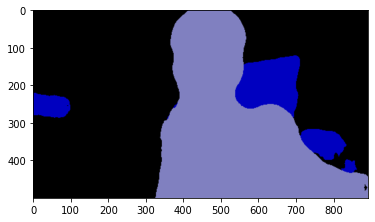

In [8]:
#segmentAsPascalvoc() 함수 를 호출하여 입력된 이미지를 분할한 뒤 나온 결과값 중 output을 matplotlib을 이용해 출력
plt.imshow(output)
plt.show()

In [9]:
segvalues # segmentAsPascalvoc() 함수를 호출하여 입력된 이미지를 분할한 뒤 나온 결과값 중 배열값을 출력

{'class_ids': array([ 0,  9, 15]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True]])}

In [10]:
#segvalues에 있는 class_ids를 담겨있는 값을 통해 pacalvoc에 담겨있는 라벨을 출력
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
chair
person


output에는 세그멘테이션이 된 결과가 각각 다른 색상으로 담겨 있네요. segvalues에는 class_ids와 masks가 있습니다. class_ids를 통해 어떤 물체가 담겨 있는지 알 수 있군요!

이제 물체마다 output에 어떤 색상으로 나타나 있는지만 알아내면 될 것 같습니다.

In [11]:
# 아래 코드를 이해하지 않아도 좋습니다
# PixelLib에서 그대로 가져온 코드입니다
# 주목해야 할 것은 생상 코드 결과물이예요!

#컬러맵 만들기 
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20] #생성한 20개의 컬러맵 출력

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

PixelLib에 따르면 위와 같은 색을 사용했다고 하네요. 그럼 사람을 나타내는 15번째 색상은 무엇일까요?

In [12]:
colormap[15] #컬러맵 15에 해당하는 배열 출력 (pacalvoc에 LABEL_NAMES 15번째인 사람)

array([192, 128, 128])

사람 외에도 다른 물체를 찾아내고 싶다면 colormap[class_id]처럼 찾아낼 수 있겠네요!

여기서 주의할 것은 output 이미지가 BGR 순서로 채널 배치가 되어 있다는 점이에요. colormap은 RGB 순서이고요.

그러니 우리가 추출해야 하는 색상 값은 순서를 아래처럼 바꿔 줘야 합니다.


In [13]:
seg_color = (128,128,192) # 색상순서 변경 - colormap의 배열은 RGB 순이며 output의 배열은 BGR 순서로 채널 배치가 되어 있어서

이제 seg_color로만 이루어진 마스크를 만들어 봅시다.





(500, 892)


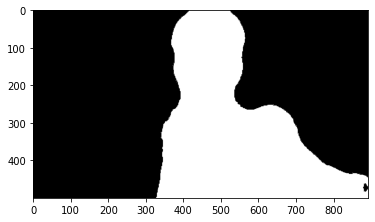

In [14]:
# output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)이 됩니다
# seg_color 값이 person을 값이 므로 사람이 있는 위치를 제외하고는 gray로 출력
# cmap 값을 변경하면 다른 색상으로 확인이 가능함
seg_map = np.all(output==seg_color, axis=-1) 
print(seg_map.shape) 
plt.imshow(seg_map, cmap='gray')
plt.show()

어떤가요? 3채널 가졌던 원본과는 다르게 채널 정보가 사라졌습니다.

이제 아래처럼 물체가 있는 위치는 1(True), 그 외에는 0(False)인 배열이 되었습니다.

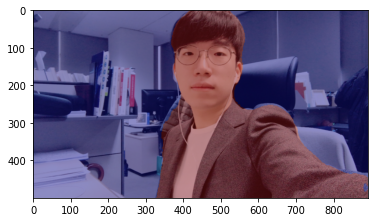

In [15]:
# 원본이미지를 img_show에 할당한뒤 이미지 사람이 있는 위치와 배경을 분리해서 표현한 color_mask 를 만든뒤 두 이미지를 합쳐서 출력
img_show = img_orig.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

## 3-5. 셸로우 포커스 만들기 (4) 배경 흐리게 하기

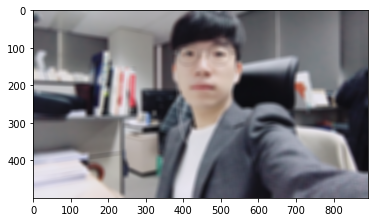

In [22]:
# (13,13)은 blurring kernel size를 뜻합니다
# 다양하게 바꿔보세요
img_orig_blur = cv2.blur(img_orig, (13,13))

# plt.imshow(): 저장된 데이터를 이미지의 형식으로 표시한다.
# cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
# cv2.COLOR_BGR2RGB: 원본이 BGR 순서로 픽셀을 읽다보니
# 이미지 색상 채널을 변경해야함 (BGR 형식을 RGB 형식으로 변경)   
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

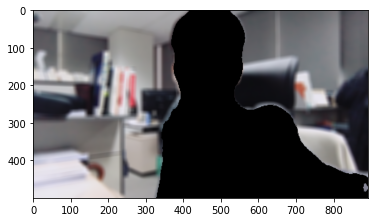

In [17]:
# cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
# cv2.COLOR_BGR2RGB: 원본이 BGR 순서로 픽셀을 읽다보니
# 이미지 색상 채널을 변경해야함 (BGR 형식을 RGB 형식으로 변경) 
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)

# cv2.bitwise_not(): 이미지가 반전됩니다. 배경이 0 사람이 255 였으나
# 연산을 하고 나면 배경은 255 사람은 0입니다.
img_bg_mask = cv2.bitwise_not(img_mask_color)

# cv2.bitwise_and()을 사용하면 배경만 있는 영상을 얻을 수 있습니다.
# 0과 어떤 수를 bitwise_and 연산을 해도 0이 되기 때문에 
# 사람이 0인 경우에는 사람이 있던 모든 픽셀이 0이 됩니다. 결국 사람이 사라지고 배경만 남아요!
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

bitwise_not 함수를 이용하면 이미지가 반전됩니다. 원래 마스크에서는 배경이 0, 사람이 255였으니 bitwise_not 연산을 하고 나면 배경은 255, 사람은 0이 되겠죠?

반전된 세그멘테이션 결과를 이용해서 이미지와 bitwise_and 연산을 수행하면 배경만 있는 영상을 얻을 수 있습니다. 0과 어떤 수를 bitwise_and 연산을 해도 0이 되기 때문에 사람이 0인 경우에는 사람이 있던 모든 픽셀이 0이 됩니다. 결국 사람이 사라지게 되는 거죠.

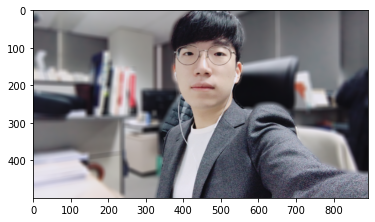

In [25]:
# np.where(조건, 참일때, 거짓일때)
# 세그멘테이션 마스크가 255인 부분만 원본 이미지 값을 가지고 오고 
# 아닌 영역은 블러된 이미지 값을 사용합니다.
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
# plt.imshow(): 저장된 데이터를 이미지의 형식으로 표시한다.
# cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
# cv2.COLOR_BGR2RGB: 원본이 BGR 순서로 픽셀을 읽다보니 
# 이미지 색상 채널을 변경해야함 (BGR 형식을 RGB 형식으로 변경)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

세그멘테이션 마스크가 255인 부분만 원본 이미지 값을 가지고 오고 아닌 영역은 블러된 이미지 값을 사용합니다. np.where(조건, 참일때, 거짓일때)의 형식의 코드를 사용했네요.

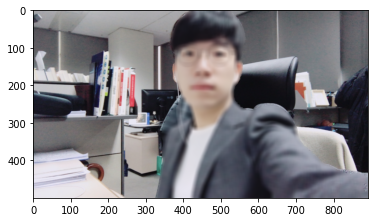

In [26]:
# Q. 이번에는 사람 부분을 블러로, 배경 부분을 원본으로 출력해볼까요?
# 힌트 : img_mask_color 옵션을 적절히 조정해주고, img_orig, img_orig_blur 를 활용하세요.
img_concat = np.where(img_mask_color==0, img_orig, img_orig_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()